# Cats and dogs with pretrained convnet (III - fine tuning)

In [1]:
from keras import models
from keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from keras import optimizers

from keras.applications import VGG16

import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Define folders

In [2]:
base_dir = './cats_and_dogs_small/'

In [3]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Load pretrained convnet

In [4]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Define total model

In [5]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [7]:
print('This is the number of trainable weight tensor before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weight tensor before freezing the conv base: 30


In [8]:
#model.trainable_weights

In [9]:
conv_base.trainable = False

In [10]:
print('This is the number of trainable weight tensors after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weight tensors after freezing the conv base: 4


In [11]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(8192, 256) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32_ref>]

# Data augmentation configuration

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, width_shift_range=0.2, 
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [13]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.


In [15]:
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, 
                                                        class_mode='binary')

Found 1000 images belonging to 2 classes.


# Compile

In [16]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

# Fit

In [17]:
#Note: steps_per_epoch=100 so 2000/20=100 where 20 is the dimension of the batch and 2000 is the total train images
#NOT valid anymore because now there are many more figures, not just 2000!!!!

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch=200, epochs=30, validation_data=validation_generator, 
                              validation_steps=100)

Epoch 1/30
200/200 [==============================] - 22s 111ms/step - loss: 1.3706 - acc: 0.8357 - val_loss: 0.5343 - val_acc: 0.9270
Epoch 2/30
200/200 [==============================] - 21s 106ms/step - loss: 0.7298 - acc: 0.9002 - val_loss: 0.3262 - val_acc: 0.9600
Epoch 3/30
200/200 [==============================] - 21s 106ms/step - loss: 0.6026 - acc: 0.9172 - val_loss: 0.3518 - val_acc: 0.9560
Epoch 4/30
200/200 [==============================] - 21s 107ms/step - loss: 0.4375 - acc: 0.9325 - val_loss: 0.3323 - val_acc: 0.9580
Epoch 5/30
200/200 [==============================] - 21s 106ms/step - loss: 0.4228 - acc: 0.9365 - val_loss: 0.3041 - val_acc: 0.9660
Epoch 6/30
200/200 [==============================] - 21s 106ms/step - loss: 0.3940 - acc: 0.9405 - val_loss: 0.2849 - val_acc: 0.9660
Epoch 7/30
200/200 [==============================] - 21s 106ms/step - loss: 0.3558 - acc: 0.9462 - val_loss: 0.2605 - val_acc: 0.9690
Epoch 8/30
200/200 [==============================] - 2

# Plots

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

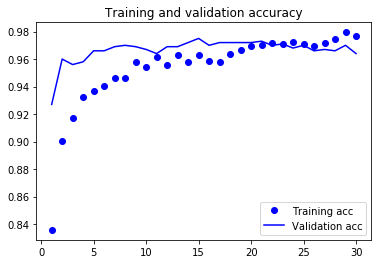

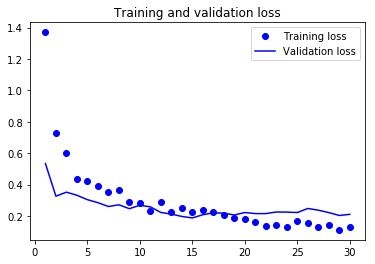

In [20]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# So far as previous mode. Now fine tuning

In [21]:
conv_base.trainable = True

### set as trainable from block5_conv1 onwards

In [22]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Compile fine tuning

In [23]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

In [24]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator,
                                validation_steps=50)

Epoch 1/30
100/100 [==============================] - 11s 113ms/step - loss: 0.1628 - acc: 0.9695 - val_loss: 0.2400 - val_acc: 0.9620
Epoch 2/30
100/100 [==============================] - 10s 104ms/step - loss: 0.1256 - acc: 0.9735 - val_loss: 0.2655 - val_acc: 0.9630
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.1242 - acc: 0.9760 - val_loss: 0.2220 - val_acc: 0.9650
Epoch 4/30
100/100 [==============================] - 10s 104ms/step - loss: 0.1257 - acc: 0.9765 - val_loss: 0.1749 - val_acc: 0.9700
Epoch 5/30
100/100 [==============================] - 10s 103ms/step - loss: 0.0913 - acc: 0.9795 - val_loss: 0.1846 - val_acc: 0.9710
Epoch 6/30
100/100 [==============================] - 10s 103ms/step - loss: 0.1019 - acc: 0.9775 - val_loss: 0.1999 - val_acc: 0.9710
Epoch 7/30
100/100 [==============================] - 10s 103ms/step - loss: 0.0703 - acc: 0.9820 - val_loss: 0.2028 - val_acc: 0.9700
Epoch 8/30
100/100 [==============================] - 1

### Plots fine tuning

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

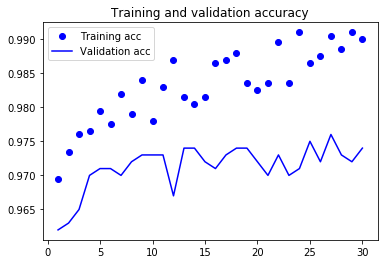

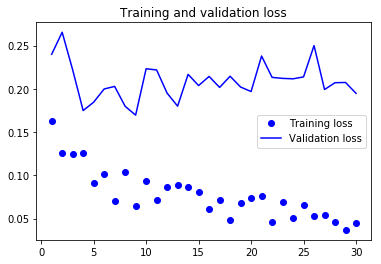

In [26]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Because it is a bit noisy we can smooth 

### (exponential moving average - EMA)

In [27]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

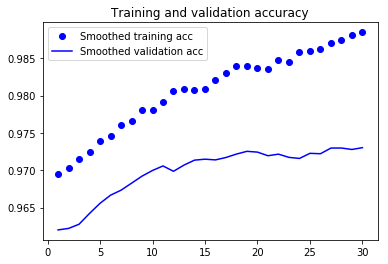

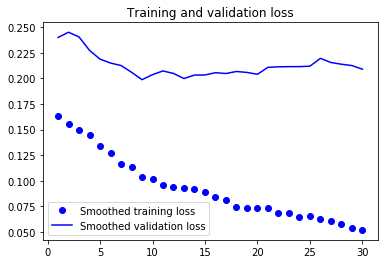

In [28]:
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate on the test set

In [29]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 1000 images belonging to 2 classes.


In [30]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

In [31]:
print('test acc:', test_acc)

test acc: 0.9689999961853027
